In [ ]:
# Kaggle COVID 19 Radiography - COVID 19 감염 예측 이미지 분류

# COVID 19 Radiography 은 감염 예측 이미지 분류
# COVID(코로나)
# Viral Pneumonia(바이러스성 폐럼)
# Lung Opacity(폐 음영 - 폐렴, 폐암, 간질성 폐 질환 등 다양한 원인)
# Normal(정상) 
# 발견하고 예측하기 위해서 Kaggle의 공개 데이터로서 총 21,165개 Chest X-Ray 이미지 데이터

# Conv Layer -> MaxPooling Layer -> Conv Layer -> MaxPooling Layer -> Conv Layer -> MaxPooling Layer
# -> Flatten Layer -> Linear -> Linear
# 데이터 다운로드 및 로드 -> 데이터 전처리(정규화 Normalization) -> 모델 아키텍처 구성 -> 모델 학습 및 평가

In [37]:
# 라이브러리
import os, shutil, zipfile, random, glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split

# GPU 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [2]:
# ===============================
# 데이터 경로 설정
# ===============================
ROOT_DIR = '.\\data'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'COVID-19_Radiography')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [3]:
# 데이터 폴더 존재시 삭제
if os.path.exists('.\\data\\COVID-19_Radiography'):
    shutil.rmtree('.\\data\\COVID-19_Radiography')
    print('./data/COVID-19_Radiography is removed')

In [4]:
# 압축 해제
with zipfile.ZipFile(os.path.join(ROOT_DIR, 'COVID-19_Radiography.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [ ]:
# 데이터 전처리 - 원본데이터 -> train 데이터 구축

# 압축을 풀면 /content/COVID-19_Radiography/COVID-19_Radiography_Dataset/label_names 처럼 분류 정답을 나타내는 4개의 디렉토리가 있음
# 각각의 label_names 디렉토리에는 classification 위한 images 디렉토리와 segmentation 위한 mask 디렉토리가 있는데
# 현재 예제에서는 classification 목적이므로 label_names/images 디렉토리만 /content/COVID-19_Radiography/train/label_names copytree 이용해서 복사함.
total_file_list = glob.glob(os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset\\*'))

# list comprehension 이용해서 'COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia' 등의 정답 리스트 생성
label_name_list = [ file_name.split('\\')[-1].strip() for file_name in total_file_list if os.path.isdir(file_name) == True ]
print(label_name_list)

for label_name in label_name_list: # 각각의 정답(label)
    src_dir_path = os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset'+'\\'+label_name+'\\images') # 원본 이미지 경로
    dst_dir_path = os.path.join(DATA_ROOT_DIR, 'train'+'\\'+label_name) # 복사될 이미지 경로

    try:
        shutil.copytree(src_dir_path, dst_dir_path) # shutil.copytree 이용해서 원본 데이터와 동일한 정답을 가지는 train 디렉토리 생성 및 이미지 복사
    except Exception as err:
        print(str(err))

if not os.path.exists(TEST_DATA_ROOT_DIR): # 원본 데이터와 동일한 정답을 가지는 test 디렉토리 생성
    os.mkdir(TEST_DATA_ROOT_DIR)

for label_name in label_name_list: # test 디렉토리의 하위 디렉토리 생성
    if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, label_name)):
        os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
[WinError 183] 파일이 이미 있으므로 만들 수 없습니다: '.\\data\\COVID-19_Radiography\\train\\COVID'
[WinError 183] 파일이 이미 있으므로 만들 수 없습니다: '.\\data\\COVID-19_Radiography\\train\\Lung_Opacity'
[WinError 183] 파일이 이미 있으므로 만들 수 없습니다: '.\\data\\COVID-19_Radiography\\train\\Normal'
[WinError 183] 파일이 이미 있으므로 만들 수 없습니다: '.\\data\\COVID-19_Radiography\\train\\Viral Pneumonia'


In [19]:
# 데이터 전처리 - train 데이터 -> test 데이터 구축

MOVE_RATIO = 0.2 # train : test = 80 : 20, train 데이터 20% 데이터를 test 데이터로 사용

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(label_name_list)

for label_name in label_name_list: # train 디렉토리의 각각 정답(label)
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name) # train 디렉토리의 정답(label) 경로
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name) # test 디렉토리의 정답(label) 경로

    train_data_file_list = os.listdir(src_dir_path) # 정답(label) 디렉토리에 있는 이미지 파일 목록을 추출
    random.shuffle(train_data_file_list) # 데이터를 섞어줌

    split_num = int(MOVE_RATIO * len(train_data_file_list))
    test_data_file_list = train_data_file_list[0:split_num] # train 데이터의 20%를 test 데이터로 사용

    for test_data_file in test_data_file_list:
        try: # train 데이터의 20%를 test 데이터로 이동
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))
        except Exception as err:
            print(str(err))

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [21]:
# 데이터 전처리 - train, test 데이터 확인
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(TRAIN_DATA_ROOT_DIR)
print(label_name_list, len(label_name_list))

for label_name in label_name_list:

    label_dir = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    print('train label : ' + label_name + ' => ', len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR,label_name))))

label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(TEST_DATA_ROOT_DIR)
print(label_name_list, len(label_name_list))

for label_name in label_name_list:

    label_dir = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    print('train label : ' + label_name + ' => ', len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR,label_name))))

.\data\COVID-19_Radiography\train
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'] 4
train label : COVID =>  2893
train label : Lung_Opacity =>  4810
train label : Normal =>  8154
train label : Viral Pneumonia =>  1076
.\data\COVID-19_Radiography\test
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'] 4
train label : COVID =>  723
train label : Lung_Opacity =>  1202
train label : Normal =>  2038
train label : Viral Pneumonia =>  269


In [43]:
# ===============================
# Dataset 준비
# ===============================
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# transforms 설정
train_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet 기준 정규화
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# datasets.ImageFolder
train_dataset = datasets.ImageFolder(TRAIN_DATA_ROOT_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(TEST_DATA_ROOT_DIR, transform=test_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 정답 label
class_names = train_dataset.classes
print('클래스 : ', class_names)

클래스 :  ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8731157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.570

torch.Size([32, 3, 224, 224]) torch.Size([32])
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}


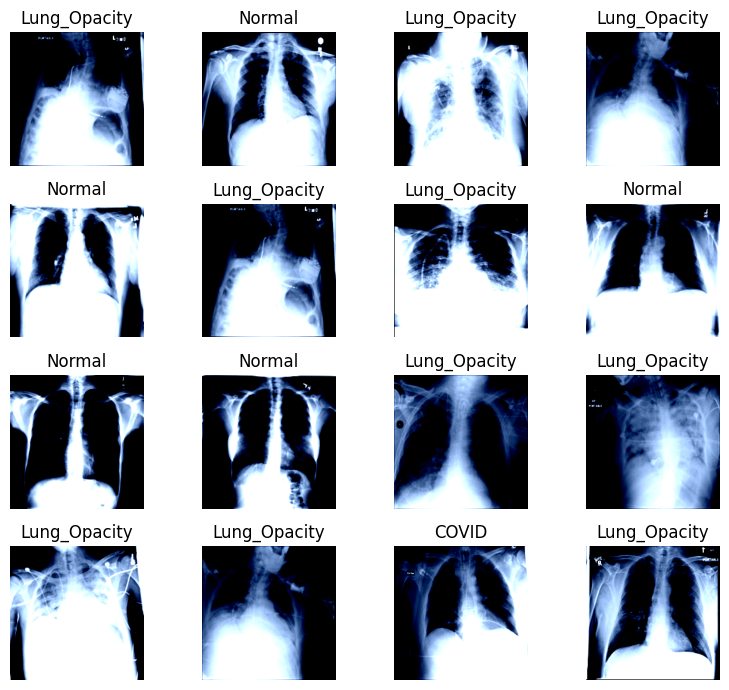

In [39]:
# 1개 배치 추출
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

# labels map 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1, )).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    plt.subplot(rows, cols, i)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [40]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1) # pre-trained model 다운로드
print(model)
print('------------------------------')
print(model.last_channel)
print('------------------------------')
print(model.classifier[1].in_features)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [46]:
# ===============================
# 모델 정의 (MobileNetV2)
# ===============================
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1) # pre-trained model 다운로드

# nn.Sequential() 구조로 설계
# model.classifier = nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Linear(model.last_channel, 512), # 마지막 입력값(in_features=1280)을 가져오는 코드 - model.last_channel or model.classifier[1].in_features
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(512, 128),
#     nn.ReLU(),
#     nn.Linear(128, len(class_names)),
#     nn.Softmax(dim=1)
# )

# MobileNet(pre-trained model) -> GlobalAveragePooling(Flatten Layer) -> Linear -> ReLU -> Dropout -> Linear -> ReLU -> softmax
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.last_channel, 64), # 마지막 입력값(in_features=1280)을 가져오는 코드 - model.last_channel or model.classifier[1].in_features
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, len(class_names)),
    nn.Softmax(dim=1)
)

In [47]:
# ======================
# 모델객체 & 손실함수 & 옵티마이저
# ======================
n_classes = len(class_names)
model = model.to(DEVICE)
print(model)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [48]:
# ===============================
# 학습 함수
# ===============================
def train_model(model, loss_function, optimizer, train_loader, val_loader, num_epochs, patience=5):
    best_loss = np.inf
    counter = 0
    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []

    for epoch in range(num_epochs):
        # --- Train ---
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad() # 미분 초기화
            outputs = model(inputs) # 모델 예측
            loss = loss_function(outputs, labels) # 손실함수 계산

            _, preds = torch.max(outputs, 1) # 예측값 분리
            loss.backward() # 미분 연산
            optimizer.step() # 미분 연산 후 파라미터(가중치, 바이어스) 업데이트

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset) # 평균 손실함수값
        epoch_acc = running_corrects.double() / len(train_loader.dataset) # 평균 정확도값
        train_loss_hist.append(epoch_loss)
        train_acc_hist.append(epoch_acc.item())

        # --- Validation ---
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad(): # 오차역전파 사용 안함, 미분 연산 하지 않음
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs) # 모델 예측
                loss = loss_function(outputs, labels) # 손실함수값 계산

                _, preds = torch.max(outputs, 1) # 예측값 분리
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset) # validation 평균 손실함수값
        val_acc = val_running_corrects.double() / len(val_loader.dataset) # validation 평균 정확도값
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f} "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                model.load_state_dict(best_model_wts)
                break

    return model, (train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist)

In [ ]:
# ===============================
# 학습 실행
# ===============================
model, history = train_model(model, loss_function, optimizer, train_loader, test_loader, num_epochs=20)

Epoch 1/20 - Train loss: 1.0345, acc: 0.7430 Val loss: 0.8357, acc: 0.9225
Epoch 2/20 - Train loss: 0.8397, acc: 0.9193 Val loss: 0.8076, acc: 0.9376
Epoch 3/20 - Train loss: 0.8140, acc: 0.9367 Val loss: 0.8022, acc: 0.9421
Epoch 4/20 - Train loss: 0.8028, acc: 0.9452 Val loss: 0.7990, acc: 0.9442
Epoch 5/20 - Train loss: 0.7955, acc: 0.9522 Val loss: 0.7960, acc: 0.9483
Epoch 6/20 - Train loss: 0.7886, acc: 0.9574 Val loss: 0.7960, acc: 0.9473
Epoch 7/20 - Train loss: 0.7847, acc: 0.9614 Val loss: 0.7928, acc: 0.9506
Epoch 8/20 - Train loss: 0.7829, acc: 0.9623 Val loss: 0.7932, acc: 0.9506
Epoch 9/20 - Train loss: 0.7787, acc: 0.9670 Val loss: 0.7938, acc: 0.9504
Epoch 10/20 - Train loss: 0.7757, acc: 0.9696 Val loss: 0.7922, acc: 0.9513
Epoch 11/20 - Train loss: 0.7740, acc: 0.9713 Val loss: 0.7903, acc: 0.9537
Epoch 12/20 - Train loss: 0.7699, acc: 0.9751 Val loss: 0.7965, acc: 0.9464
Epoch 13/20 - Train loss: 0.7701, acc: 0.9745 Val loss: 0.7962, acc: 0.9468
Epoch 14/20 - Train l

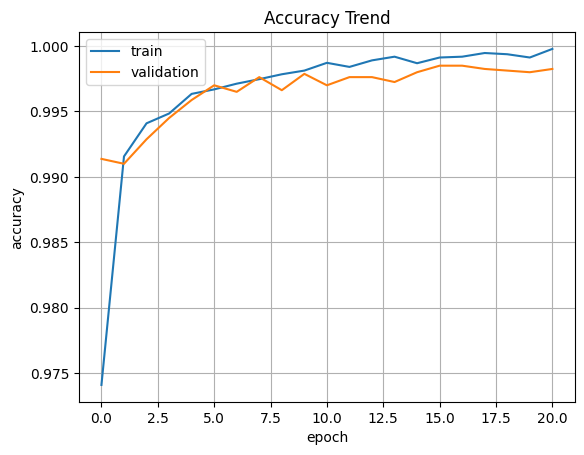

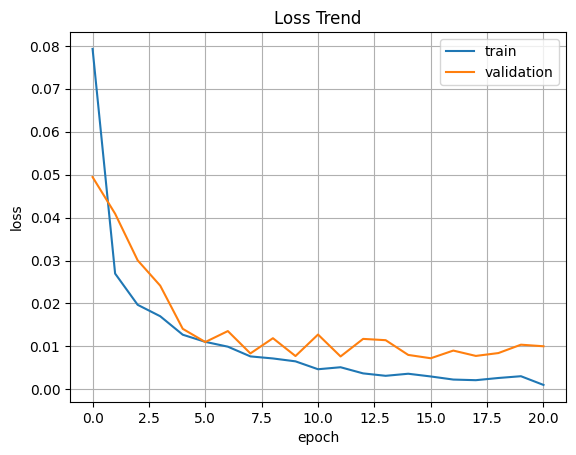

In [22]:
# ======================
# 정확도 및 손실 그래프
# ======================
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = history

plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='validation')
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='validation')
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_transfer_learning_covid19_radiography_mri.ckpt')

In [24]:
# ===============================
# 테스트 성능 평가
# ===============================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.83%
